<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/screencasts/RNN_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте попробуем сгенерировать немного шекспировской поэзии, используя знакомые нам RNN.


### Загрузка данных

Шекспировские соннеты доступны по [этой](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger) ссылке. Также сохраним их в файл.

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

--2021-10-14 16:50:35--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119747 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.03s   

2021-10-14 16:50:35 (4.53 MB/s) - ‘sonnets.txt’ saved [119747/119747]



Сделаем небольшую предобработку текста:

In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
text = ''.join(text).lower()

In [4]:
tokens = sorted(set(text))
vocab_size = len(tokens)

In [5]:
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in token_to_idx.items()}

# Создание простой модели

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Напишем класс с vanilla RNN:

In [8]:
class RNNCell(nn.Module):
  def __init__(self,
               num_tokens=len(tokens),
               embedding_size=32,
               rnn_num_units=64):
    super(RNNCell,self).__init__()
    self.num_units = rnn_num_units

    self.embedding = nn.Embedding(num_tokens, embedding_size)
    self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
    self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
  def forward(self, x, h_prev):
    x_emb = self.embedding(x)
    h_prev = h_prev.to(device)
    x_and_h = torch.cat([x_emb, h_prev], dim=1)
    h_next = self.rnn_update(x_and_h)
    h_next = torch.tanh(h_next)

    assert h_next.size() == h_prev.size()

    logits = self.rnn_to_logits(h_next)
    logits = F.log_softmax(logits, -1)

    return h_next, logits

  def initial_state(self, batch_size):
    return torch.zeros(batch_size, self.num_units, requires_grad=True)

Используем функцию потерь Negative log likelihood (NLL).

In [9]:
model = RNNCell()

criterion = nn.NLLLoss()

Для учета предыдущего контекста и правильной начальной инициализации мы построчно пробегаем по приходящей матрице и создаем матрицу вероятностей для следующих символов. Это и делает rnn_loop.


In [10]:
def rnn_loop(rnn_model, batch_ix):
  batch_size = batch_ix.size()[0]
  hid_state = rnn_model.initial_state(batch_size)
  logprobs = []

  for x_t in batch_ix.transpose(0,1):
    hid_state, logp_next = rnn_model(x_t, hid_state)
    logprobs.append(logp_next)
  
  return torch.stack(logprobs, dim=1)

Так как мы занимаемся посимвольной генерацией то нам нужна для обучения матрица со смещением на один символ вправо. Это создает функция to_matrix. 

In [11]:
def to_matrix(words, seq_length=16, dtype='int32', batch_first = True):
  if len(words) > seq_length:
    seq_length = len(words) - 1 

  words_ix = np.zeros((len(words) - seq_length, seq_length), dtype) # matrix for 1 char shifted sequences

  for i in range(len(words) - seq_length):
    words_ix[i, :] = [token_to_idx[c] for c in words[i:i+seq_length]]

  if not batch_first: # convert [batch, time] into [time, batch]
    words_ix = np.transpose(words_ix)

  return words_ix

In [12]:
batch_ix = to_matrix(text[:6], seq_length=5)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
logp_seq = rnn_loop(model.to(device), batch_ix)

In [13]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, vocab_size), 
                  actual_next_tokens.contiguous().view(-1))

In [14]:
loss.backward()
loss

tensor(3.6267, device='cuda:0', grad_fn=<NllLossBackward>)

In [15]:
from IPython.display import clear_output
from random import sample
from tqdm import notebook

model = RNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
history = []

# Тренировка RNN

Если мы посмотрим на получившуюся кривую лосс функции, то можно заметить, что она похожа на идеальную кривую обучения, без признаков к серьезному переобучению.

Размер батча у нас будет равен 128 — это длина куска текста, на котором мы будем обучать нашу сеть. MAX_LENGTH — длина последовательности для генерации текста. При обучении она нам не важна и величина окна равна 32 — мы будем пробегать по 32 символам для создания матрицы смещений символов.


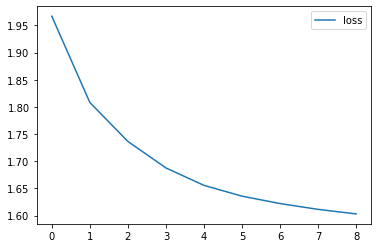

In [ ]:
STEP = 128 # some type of minibatch
MAX_LENGTH = 64
WINDOW = 32
model = model.to(device)

for i in range(25):
  for j in range(len(text) // STEP):
    
    batch_ix = to_matrix(text[j * STEP: (j + 1) * STEP], WINDOW)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq = rnn_loop(model, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, vocab_size),
        actual_next_tokens.contiguous().view(-1)
    ) 
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
  history.append(loss.item())
  if (i+1)%1==0:
      clear_output(True)
      plt.plot(history,label='loss')
      plt.legend()
      plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Функция ниже генерирует текст по фразе длиной не менее SEQ_LENGTH.

Важным параметром при генерации является температура. Ее можно представить как некое подобие энтропии — меры неопределенности системы. Чем она выше, тем хаотичнее сэмплирование. 

Обратите внимание: модель возвращает вероятности символов, а не сами символы.

In [ ]:
def generate_sample(char_rnn, seed_phrase=' hello', length=MAX_LENGTH, temperature=1.0):
    result = [token_to_idx[token] for token in seed_phrase]

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)
    
    # начало генерации
    for i in range(length):
        hid_state, logs_p = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logs_p / temperature, dim=-1).to('cpu').data[0].numpy()
        next_ix = np.random.choice(len(tokens), p=p_next)
        result.append(next_ix)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)[:, 1:]
    return ''.join([tokens[ix] for ix in result])

In [ ]:
print(generate_sample(model.to(device), 
                      seed_phrase=' hello', 
                      length=223, 
                      temperature=0.75))

# Более поэтичная модель

Перейдем к более продвинутой модели, использующей GRU-блоки. Мы будем использовать самую простую однонаправленную сеть с одним уровнем рекуррентных блоков. 

In [ ]:
WINDOW = 800

EPOCHS = 1050
LEARNING_RATE = 0.005
EMBEDDING_DIM = 64
HIDDEN_DIM = 100
NUM_HIDDEN = 1

## Предобработка

In [ ]:
tokens = sorted(set(text))
vocab_size = len(tokens)

token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for char, idx in token_to_idx.items()}

In [ ]:
def string_to_matrix(words):
    result = [token_to_idx[char] for char in words]
    result = torch.tensor(result, dtype=torch.long)
    return result

In [ ]:
def sample_text(text):
    start = np.random.randint(0, len(text) - WINDOW) + 1
    int_text = string_to_matrix(text[start:start + WINDOW + 1])
    inputs = int_text[:-1]
    outputs = int_text[1:]
    return inputs, outputs

## Модель с GRU-блоком

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size=vocab_size,
              output_size=vocab_size,   
              embed_size=EMBEDDING_DIM,
              hidden_size=HIDDEN_DIM,
              num_layers=NUM_HIDDEN):
        super(GRU, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(input_size=embed_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers)
        self.dence = nn.Linear(hidden_size, output_size)

        self.init_hidden = torch.nn.Parameter(torch.zeros(
                                              num_layers, 1, hidden_size))

    def forward(self, x, hidden):
        embed = self.embedding(x.view(1, -1))
        output, hidden =  self.gru(embed.view(1, 1, -1), hidden)
        output = self.dence(output.view(1, -1))
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def init_zero_state(self):
        init_hidden = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
        return init_hidden

In [ ]:
model = GRU(num_layers=1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Обучим нашу модель:

In [ ]:
history = []
for i in range(750):

    ### FORWARD AND BACK PROP

    hidden = model.init_zero_state().to(device)
    
    loss = 0.
    inputs, targets = sample_text(text)
    inputs, targets = inputs.to(device), targets.to(device)
    for c in range(WINDOW):
        outputs, hidden = model(inputs[c], hidden)
        loss += F.nll_loss(outputs, targets[c].view(1))

    loss /= WINDOW
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    history.append(loss.item())
    if (i+1)%50==0:
      clear_output(True)
      plt.plot(history,label='loss')
      plt.legend()
      plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

На сей раз GRU обучается чуть быстрее. Это связано с тем, что мы использовали более быстрый проход по тексту скользящим окном. Потому мы получили не такую пологую функцию потерь на кривой обучения. 

In [ ]:
def predict(model, seed_sequence, length=100, temperature=0.75):
    hidden = model.init_zero_state().to(device)
    given_input = string_to_matrix(seed_sequence).to(device)
    predicted = seed_sequence

    for i in range(len(seed_sequence) - 1):
        _, hidden = model(given_input[i], hidden)
    inp = given_input[-1].to(device)
    
    for p in range(length):
        output, hidden = model(inp, hidden)
        
        output = output.detach().cpu()
        output_dist = F.softmax(output / temperature, dim=-1).to('cpu').data[0].numpy()
        next_char = np.random.choice(len(tokens), p=output_dist)
        
        predicted_char = idx_to_token[next_char]
        predicted += predicted_char
        inp = string_to_matrix(predicted_char).to(device)

    return predicted

In [ ]:
print(predict(model, ' hello', 500, 0.65))

Посмотрим, что получается при различных значениях температуры. 

In [ ]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(predict(model, ' hello', 500, temp), end=f"\nsample for temperature -> {temp}\n\n\n")

На сей раз GRU-четко уловила структуру текста, и даже проскакивает рифма в придуманном моделью тексте. 